# 使用 PINN 求解 2D Poisson 方程式

本筆記本將演示如何使用物理訊息神經網絡（Physics-Informed Neural Networks, PINN）來解決一個二維（2D）的 Poisson 方程式。Poisson 方程式是橢圓形偏微分方程（PDE）中的一個典型例子，在物理學和工程學中有多種應用，例如靜電學、熱傳導和流體力學。

### 問題定義

- **偏微分方程 (PDE):** 
$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x, y) $$
- **源函數 (Source function):** 
$$ f(x, y) = -2 \pi^2 \sin(\pi x) \sin(\pi y) $$
- **計算域 (Domain):** 
$$ x \in [-1, 1], \quad y \in [-1, 1] $$
- **邊界條件 (Boundary Conditions):** 在整個邊界上 `u(x, y) = 0` (Dirichlet 邊界條件)。
- **解析解 (Analytical Solution):** 
$$ u(x, y) = \sin(\pi x) \sin(\pi y) $$

我們將使用 `deepxde` 函式庫來建立、訓練和評估 PINN 模型。



In [67]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 為繪圖設置樣式
sns.set_style("whitegrid")

print(f"DeepXDE backend set to: {dde.backend.backend_name}")

DeepXDE backend set to: pytorch


### 階段 1：定義幾何與 PDE

首先，我們需要定義問題的幾何邊界、PDE 方程式、邊界條件以及用於驗證的解析解。

#### 1.1 定義幾何
我們使用 `deepxde.geometry.Rectangle` 來定義一個二維的矩形計算域，其 x 和 y 座標範圍均為 `[-1, 1]`。



In [68]:
# 1. 定義幾何
geom = dde.geometry.Rectangle([-1, -1], [1, 1])

#### 1.2 定義 PDE
接下來，我們定義 Poisson 方程式的殘差形式。`deepxde` 會最小化這個殘差的 L2 範數，使其趨近於零。

- `pde(x, u)` 函數接收兩個參數：
  - `x`：一個 2D 張量，`x[:, 0:1]` 代表 x 座標，`x[:, 1:2]` 代表 y 座標。
  - `u`：神經網絡的輸出，代表 PDE 的解。
- 我們使用 `dde.grad.hessian` 來計算 `u` 對 `x` 和 `y` 的二階偏導數，從而得到拉普拉斯算子 $\nabla^2 u$。
- 函數返回 `拉普拉斯算子 - 源函數`，這就是 PDE 的殘差。
  

In [69]:
# 2. 定義 PDE
def pde(x, u):
    """
    定義 Poisson 方程式的殘差。
    x 是一個 2D 張量，其中 x[:, 0:1] 是 x 座標，x[:, 1:2] 是 y 座標。
    """

    """
    在 dde.grad.hessian(u, x, i, j) 中：
    - i, j 表示對哪些輸入變數進行二階偏微分
    - x 是輸入張量，形狀為 [batch_size, input_dim]
    - 對於 2D 問題：x[:, 0] 是 x 座標，x[:, 1] 是 y 座標

    因此：
    - i=0, j=0：表示 ∂²u/∂x² (對 x 座標進行兩次偏微分)
    - i=1, j=1：表示 ∂²u/∂y² (對 y 座標進行兩次偏微分)
    - i=0, j=1 或 i=1, j=0：表示 ∂²u/∂x∂y (混合偏微分)

    拉普拉斯算子 ∇²u = ∂²u/∂x² + ∂²u/∂y²，所以需要 i=0,j=0 和 i=1,j=1 的項
    """
    # Laplacian: d^2(u)/d(x^2) + d^2(u)/d(y^2)
    laplacian = dde.grad.hessian(u, x, i=0, j=0) + dde.grad.hessian(u, x, i=1, j=1)
    
    # 源函數 f(x, y)
    x_coord, y_coord = x[:, 0:1], x[:, 1:2]
    source = -2 * np.pi**2 * dde.backend.sin(np.pi * x_coord) * dde.backend.sin(np.pi * y_coord)
    
    return laplacian - source


# %% cell 6.5 markdown

# #### 為什麼是 laplacian - source？
# 
# Poisson 方程式的標準形式為：
# ```
# ∇²u = f(x, y)
# ```
# 
# 要讓神經網絡學習這個方程式，我們需要將它轉換為殘差形式（residual form）：
# ```
# ∇²u - f(x, y) = 0
# ```
# 
# 在 PINN 的訓練過程中，我們希望這個殘差盡可能接近零。因此：
# - `laplacian` 對應 ∇²u（拉普拉斯算子）
# - `source` 對應 f(x, y)（源函數）
# - `laplacian - source` 對應 ∇²u - f(x, y)（殘差）
# 
# 當殘差為零時，表示神經網絡的輸出 u 滿足 Poisson 方程式。
# `deepxde` 會自動最小化這個殘差的 L2 範數，使其趨近於零。


#### 1.3 定義解析解
我們定義了問題的解析解，主要用於：
1.  在訓練過程中，計算測試點上的預測誤差（L2 相對誤差）。
2.  在訓練結束後，將 PINN 的預測結果與真實解進行比較，以視覺化模型的準確性。


In [70]:
# 用於驗證的解析解
def analytical_solution(x):
    # 根據輸入類型，選擇使用 np.sin 或 dde.backend.sin
    # dde.data.PDE 會傳入 NumPy 陣列，而模型內部會使用 Tensors
    sin = np.sin
    print("x is a Tensor")
    return sin(np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])

#### 1.4 定義邊界條件
我們需要施加 Dirichlet 邊界條件，即在計算域的整個邊界上 `u(x, y) = 0`。

- 我們使用 `dde.DirichletBC` 來定義這個條件。
- `geom`：指定邊界條件應用的幾何對象。
- `lambda x: 0`：表示在邊界上的期望值為 0。
- `lambda _, on_boundary: on_boundary`：這是一個過濾器函數，用於識別哪些點位於邊界上。`geom.on_boundary(x)` 會對每個點 `x` 進行判斷，如果點在邊界上，則返回 `True`，否則返回 `False`。`deepxde` 會自動將這個條件應用於所有邊界點。
  


In [71]:
# 3. 定義邊界條件
# geometry 物件的 on_boundary 方法可以方便地識別所有邊界點。
bc = dde.DirichletBC(geom, lambda x: 0, lambda _, on_boundary: on_boundary)

# %% cell 10.5 markdown

# #### 1.4.1 邊界條件函數說明
# 在上面的代碼中，我們使用了 `lambda _, on_boundary: on_boundary` 作為邊界條件的過濾器函數。
# 這裡的 `on_boundary` 參數是由 `deepxde` 自動提供的，不需要我們手動定義。
# 
# `deepxde` 的 `DirichletBC` 工作原理：
# - 當 `deepxde` 調用邊界條件函數時，它會傳入兩個參數：
#   - 第一個參數：點的坐標 `x`（在這裡我們用 `_` 表示不使用）
#   - 第二個參數：`on_boundary` 布爾值，表示該點是否在邊界上
# - 函數應該返回一個布爾值，告訴 `deepxde` 是否在該點應用邊界條件
# - 由於我們要在所有邊界點上應用條件，所以直接返回 `on_boundary`
# 



### 階段 2：組裝與訓練模型

定義完問題的各個組成部分後，我們現在可以將它們組裝成一個 PINN 模型並開始訓練。

#### 2.1 建立訓練數據
我們使用 `dde.data.PDE` 來整合幾何、PDE 和邊界條件，並指定用於訓練和測試的數據點數量。
- `num_domain=2500`：在計算域內部隨機採樣 2500 個點，用於最小化 PDE 殘差。
- `num_boundary=100`：在邊界上採樣 100 個點，用於滿足邊界條件。
- `solution=analytical_solution`：提供解析解，`deepxde` 會使用它來計算 L2 相對誤差。
- `num_test=1000`：生成 1000 個測試點，用於在訓練過程中監控模型的泛化能力。

#### 2.2 定義神經網絡
我們建立一個前饋神經網絡（FNN）來近似 PDE 的解 `u(x, y)`。
- `[2] + [50] * 3 + [1]`：
  - 輸入層有 2 個神經元（對應 x 和 y）。
  - 3 個隱藏層，每層有 50 個神經元。
  - 輸出層有 1 個神經元（對應 u）。
- `"tanh"`：使用 tanh 作為活化函數。
- `"Glorot normal"`：使用 Glorot normal 方法進行權重初始化。

#### 2.3 編譯與訓練模型
- 我們將數據和網絡傳入 `dde.Model` 來建立 PINN 模型。
- 使用 Adam 優化器，學習率設定為 `1e-3`。
- 訓練模型 20000 次迭代。



In [ ]:
# 4. 組裝與訓練模型
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=2500,
    num_boundary=100,
    solution=analytical_solution,
    num_test=1000,
)

# 網絡架構：2 個輸入 (x, y)，3 個隱藏層，每層 50 個神經元，1 個輸出 (u)
net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# 使用 Adam 優化器和 1e-3 的學習率進行編譯
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

# 訓練模型 20000 次迭代
losshistory, train_state = model.train(iterations=20000, display_every=1000)


# %% cell 12.1 markdown

# ### 關於訓練輸出的說明
# 
# 在訓練過程中，您可能注意到輸出格式如下：
# ```
# 1000      [8.25e-03, 1.61e-02]    [5.99e-03, 1.61e-02]    [1.20e-01]
# ```
# 
# 這裡有兩組數值的原因是：
# 
# 1. **第一組 `[8.25e-03, 1.61e-02]`**：訓練損失
#    - `8.25e-03`：PDE 殘差損失（在域內點的 PDE 方程誤差）
#    - `1.61e-02`：邊界條件損失（在邊界點的邊界條件誤差）
# 
# 2. **第二組 `[5.99e-03, 1.61e-02]`**：測試損失
#    - `5.99e-03`：測試集上的 PDE 殘差損失
#    - `1.61e-02`：測試集上的邊界條件損失
# 
# 3. **第三個值 `[1.20e-01]`**：L2 相對誤差
#    - 這是測試集上預測解與解析解的 L2 相對誤差
# 
# PINN 的總損失是各個組件損失的加權和：
# **總損失 = PDE 殘差損失 + 邊界條件損失**
# 
# 監控這些分別的損失有助於我們理解：
# - 模型是否在正確學習 PDE 的物理規律（PDE 損失）
# - 模型是否滿足邊界條件（BC 損失）
# - 模型的整體準確性（L2 誤差）


# %% cell 12.2 markdown

# ### 為什麼訓練輸出中沒有顯示 "Total Loss"？
# 
# 您可能疑惑為什麼在訓練輸出中只看到各個組件的損失，而沒有直接顯示總損失。這是因為：
# 
# 1. **DeepXDE 的設計理念**：DeepXDE 選擇顯示各個損失組件，讓用戶能夠：
#    - 監控每個物理約束的滿足程度
#    - 診斷訓練過程中的問題（例如某個組件損失不收斂）
#    - 更好地理解模型的學習過程
# 
# 2. **總損失的計算**：雖然沒有直接顯示，但總損失實際上就是：
#    ```
#    總損失 = PDE 損失 + 邊界條件損失 = 8.25e-03 + 1.61e-02 = 2.435e-02
#    ```
# 
# 3. **這種設計的優勢**：
#    - **問題診斷**：如果 PDE 損失很小但 BC 損失很大，說明模型學會了方程但沒有很好地滿足邊界條件
#    - **平衡調整**：可以根據各組件的收斂情況調整損失權重
#    - **物理洞察**：幫助理解模型在學習哪些物理約束方面有困難
# 
# 4. **如果需要查看總損失**：可以透過以下方式獲得：
#    ```python
#    # 訪問訓練歷史中的總損失
#    total_loss = losshistory.loss_train  # 包含每次迭代的總損失
#    ```



x is a Tensor
x is a Tensor
Compiling model...
'compile' took 0.000110 s

Training model...

0         [9.37e+01, 6.53e-02]    [1.04e+02, 6.53e-02]    [1.08e+00]
1000      [8.25e-03, 1.61e-02]    [5.99e-03, 1.61e-02]    [1.20e-01]
2000      [2.82e-03, 1.12e-02]    [2.05e-03, 1.12e-02]    [1.02e-01]
3000      [3.47e-03, 7.33e-03]    [2.76e-03, 7.33e-03]    [8.30e-02]
4000      [4.95e-03, 4.74e-03]    [4.33e-03, 4.74e-03]    [6.78e-02]
5000      [1.52e-03, 2.81e-03]    [1.17e-03, 2.81e-03]    [5.14e-02]
6000      [1.19e-03, 1.77e-03]    [9.91e-04, 1.77e-03]    [4.14e-02]
7000      [1.22e-03, 1.10e-03]    [1.05e-03, 1.10e-03]    [3.25e-02]
8000      [9.45e-04, 6.96e-04]    [8.29e-04, 6.96e-04]    [2.55e-02]
9000      [6.78e-04, 4.53e-04]    [5.64e-04, 4.53e-04]    [2.05e-02]
10000     [6.63e-04, 3.02e-04]    [5.45e-04, 3.02e-04]    [1.63e-02]
11000     [4.85e-04, 2.27e-04]    [4.35e-04, 2.27e-04]    [1.45e-02]
12000     [5.18e-04, 1.74e-04]    [4.79e-04, 1.74e-04]    [1.27e-02]
13000     

### 階段 3：結果視覺化

訓練完成後，我們將損失歷史和最終的預測結果視覺化，以評估模型的性能。

#### 3.1 繪製損失歷史
`deepxde` 提供了方便的工具來繪製損失函數隨訓練迭代次數的變化。這有助於我們了解訓練過程的收斂情況。



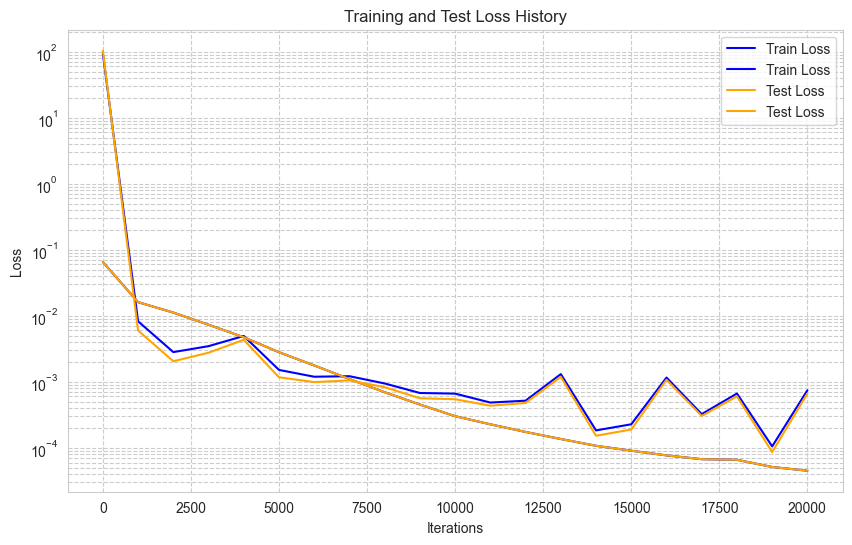

In [77]:
# Plot the loss history
plt.figure(figsize=(10, 6))
train_loss = np.array(losshistory.loss_train)
test_loss = np.array(losshistory.loss_test)
steps = losshistory.steps

plt.plot(steps, train_loss, label="Train Loss", color='blue')
plt.plot(steps, test_loss, label="Test Loss", color='orange')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Test Loss History")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



#### 3.2 視覺化解
為了評估 PINN 預測的準確性，我們將 PINN 的解、解析解以及兩者之間的絕對誤差進行 3D 繪圖比較。

1.  我們建立一個 100x100 的網格來覆蓋整個計算域。
2.  使用訓練好的模型 `model.predict()` 在網格點上進行預測。
3.  計算網格點上的解析解。
4.  計算 L2 相對誤差，這是一個衡量整體預測精度的指標。
5.  使用 `matplotlib` 將 PINN 解、解析解和絕對誤差繪製成 3D 曲面圖，以便直觀比較。


x is a Tensor
L2 relative error: 5.9763e-03


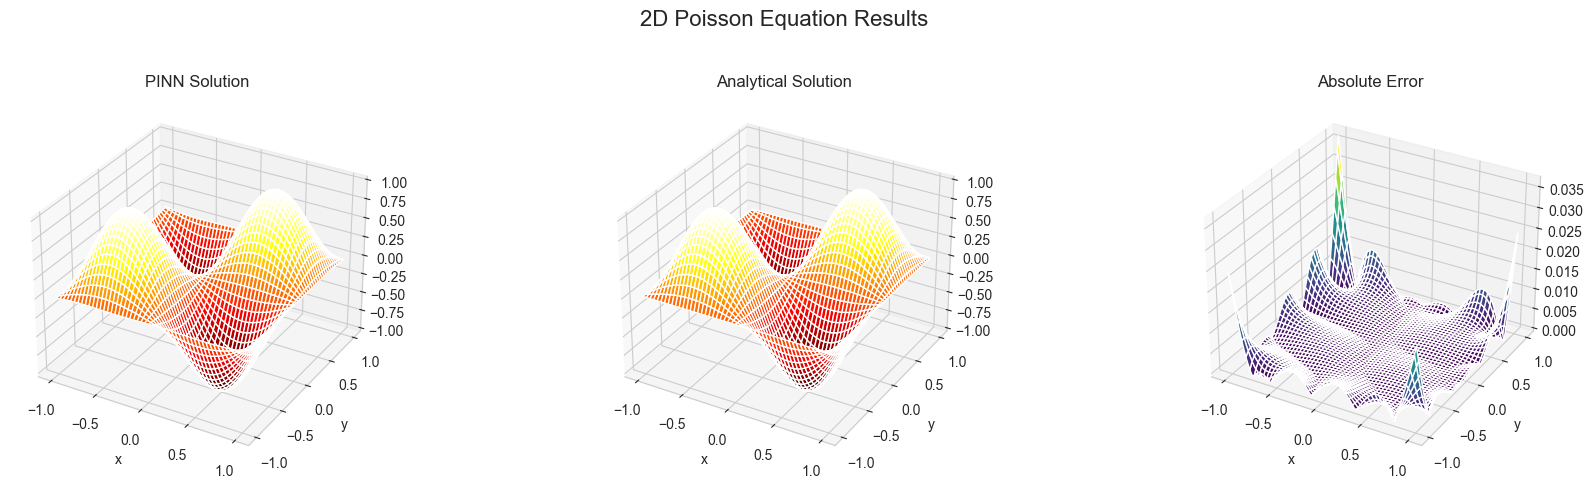

In [ ]:
# 5. 視覺化解
# 建立用於預測的網格
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
xy_test = np.vstack((X.flatten(), Y.flatten())).T

# 在網格上進行預測
u_pred = model.predict(xy_test)
u_pred_grid = u_pred.reshape(100, 100)

# 獲取網格上的解析解
# 由於 analytical_solution 現在可以處理 NumPy 輸入，我們不再需要手動轉換 Tensor
u_analytical_grid = analytical_solution(xy_test).reshape(100, 100)

# 計算 L2 相對誤差
l2_error = dde.metrics.l2_relative_error(u_analytical_grid, u_pred_grid)
print(f"L2 relative error: {l2_error:.4e}")

# 繪圖
fig = plt.figure(figsize=(18, 5))

# PINN 解
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(X, Y, u_pred_grid, cmap='hot')
ax1.set_title('PINN Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# 解析解
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(X, Y, u_analytical_grid, cmap='hot')
ax2.set_title('Analytical Solution')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# 誤差
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
error = np.abs(u_pred_grid - u_analytical_grid)
ax3.plot_surface(X, Y, error, cmap='viridis')
ax3.set_title('Absolute Error')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

plt.suptitle("2D Poisson Equation Results", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

